# Conjunto de funciones y analisis prelimilares  

Arturo Sirvent Fresneda 


In [1]:
#librerias
import mne 
import yasa
import numpy as np
import matplotlib.pyplot as plt 
import os 
import re
import pandas as pd 
import scipy
from sklearn.metrics import accuracy_score

In [34]:
#cargamos los datos y les hacemos todo lo de resamplear y eliminar los ultimos 30 y tal

raw = mne.io.read_raw_edf('../data/from_web/9/9.edf', preload=True)
raw.resample(100)
raw.filter(0.3, 45)
data = raw.get_data() * 1e6 #para pasarlo a microVolts, porque MNE lo pasa a Volts
data1=data[:,:-30*30*100]
raw.crop(0,data1.shape[1]/100,include_tmax=False)
data = raw.get_data() * 1e6 #para pasarlo a microVolts, porque MNE lo pasa a Volts


#vamos a cargar las labels que asignamos a cada uno de los batches de 30 segundos (épocas).
hypno1 = pd.read_csv("../data/from_web/9/9_1.txt", squeeze=True,header=None)
hypno2 = pd.read_csv("../data/from_web/9/9_2.txt", squeeze=True,header=None)
print(hypno1.shape,hypno2.shape)
hypno1[hypno1==5]=4
hypno2[hypno2==5]=4

#tenemos que quitar las últimas 30 epocas porque son "erroneas"

hypno1=hypno1[:-30]
hypno2=hypno2[:-30]
print(hypno1.shape,hypno2.shape)


Extracting EDF parameters from /home/arturo/Documentos/MASTER_CD/Segundo_Cuatrimestre/CDBio/trabajo_final_sueno/data/from_web/9/9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 1101 samples (11.010 sec)

(969,) (969,)
(939,) (939,)


Los datos que cargamos son analizados en ventanas temporales de 30 segundos, y en un excel nos salen anotaciones de estos intervalos, teniendo anotaciones aquellos que no estás del todo bien. Vamos a impementar una función que nos elimine todos esos intervalos que no estan limpios.


Queremos una función que nos tenga en cuenta varias cosas para asi poder cargar los datos mas limpios:  
* Eliminar registros con eventos.  
* Eliminar los registros anteriores al _Lights Out_.  
* Eliminar los 30 útimos registros. 

In [35]:
#vamos a meter todo en una función
def load_valid_data(file_dir,return_bool_vect=False):
    #en esta duncion añadimos automaticamente lo de eliminarlas ultimas 30!!
    #se cargan los datos del excel
    anotaciones_hypno1=pd.read_excel(file_dir)
    merge_aux=anotaciones_hypno1["Events"].astype("str")+ anotaciones_hypno1["HR"].astype("str")
    merge_aux=merge_aux.apply(str.strip,args=(["nan"]))
    numeros=[re.findall("[0-9]{2,3}",i)[0] for i in merge_aux]
    anotaciones=[re.findall("\D+",i) for i in merge_aux]
    #si está vacia le ponemos un 0 y en el resto -1 
    anotaciones1=[ -1 if i else 0 for i in anotaciones ]

    #tambien vamos a poner a -1 todas las anteriores a la que dice lights out por primera vez
    for i,j in enumerate(anotaciones):
        if "L Out" in [k.strip() for k in j]: #igual habria que mejor la forma en que busca el lights out, no se
            break
        elif i>20:
            print("igual algo pasa, no hay lights out")
        else:
            anotaciones1[i]=-1

    #de esta forma obtenemos todas las epocas no válidas, con un -1 
    #anotaciones1

    #para poner esto en una forma más accesible, podemos crear un 
    #vector booleano o uno que contenga los indices validos
    if return_bool_vect:
        bool_vect = np.array(anotaciones1)==0
        #aqui ponemos los ultimos 30 a False, como si tuviera anotaciones, no validos
        bool_vect[-30:]=False
        
        #devolvemos en True los que no tienen anotaciones
        return bool_vect
    
    else:
        indices_validos = np.array([i[0] for i in np.argwhere(np.array(anotaciones1[:-30])==0)])

        return indices_validos

In [36]:
indices=load_valid_data("../data/from_web/9/9_1.xlsx",return_bool_vect=False)
indices

array([  4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  17,
        18,  19,  20,  22,  23,  24,  25,  26,  27,  28,  30,  31,  33,
        35,  36,  38,  39,  40,  41,  42,  43,  44,  45,  48,  50,  51,
        53,  54,  55,  57,  59,  62,  63,  64,  65,  76,  86,  88,  89,
        90,  91,  93,  94,  95,  97,  98,  99, 100, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 22

Ahora las funciones que usaremos para clasificar y analizar los resultados de pertenencia estadística a uno u otro intervalo del sueño.  

La forma de pasar los datos para que aplicar diferentes humbrales a cada uno de los estados del sueño, será en una lista de listas, indicando para cada época, la probabilidad de cada estado del sueño (["W","R","N1","N2","N3"]). 

In [37]:
def intermedia1(y_porcentajes,umbrales):
    #esta funcion nos hace el primer stage de convertir a numpy y filtrar segun el humbral, poniendo 0
    #en las que no pasan el humbral impuesto
    if isinstance(y_porcentajes, pd.DataFrame): 
        y_porcentajes=y_porcentajes.to_numpy()
        
    #vamos a darle 
    lista_aux=[]
    for ind,i in enumerate(umbrales):
        aux=y_porcentajes[:,ind]
        lista_aux.append(np.where(aux>i, aux, 0))
    #ahora tenemos una lista de listas, pero podemos hacerlo array
    return np.array(lista_aux).T

def count_by_thresh(y_porcentajes,umbrales=None):
    #una funcion que le damos unas probs, unos umbrales para cada canal y unas etiquetas reales
    #nos devuelve las counts de fases no seleccionadas, las clasificadas bien, y las mal

    # !! TENEMOS QUE PASARLE EN ESTE ORDEN LAS FASES ¡¡ 
    
    #los nombres de los stages son ["W","R","N1","N2","N3"] ó [0,1,2,3,4,5]
    #stages=np.array(["W","R","N1","N2","N3"])
    stages=np.arange(0,6)
    
    if isinstance(y_porcentajes, pd.DataFrame): 
        y_porcentajes=y_porcentajes.to_numpy()
        
    #Hacemos el filtrado
    filtrado=intermedia1(y_porcentajes,umbrales)
    
    
    #ahora determinamos las filas sin registro valido, las cuales se encargará la medico de clasificar
    #y para las otras guardamos el indice o nombre del stage que si esta por encima del umbral.
    lista_stages_valid=[]
    probs_stages_valid=[]
    for i in filtrado: 
        indexs=np.nonzero(i)[0]
        if indexs.size>0:
            lista_stages_valid.append(list(stages[indexs]))
            probs_stages_valid.append(list(i[indexs]))
        else:
            lista_stages_valid.append(-1)
            probs_stages_valid.append(-1)
    
    #devuelve las fases aceptadas en los interalos datos, y las probabilidades de estas
    #si una epoca no tiene ninguna fase que haya tenido alguna por encima de los umbrales,
    #le ponemos un -1 y podemos tener mas de una fase del sueño por encima de los umbrales.
    return probs_stages_valid,lista_stages_valid

In [6]:
# !! TENEMOS QUE PASARLE EN ESTE ORDEN LAS FASES ¡¡
#a,b=curva_rock(proba[["W","R","N1","N2","N3"]],[0.9,0.1,0.1,0.1,0.9])

## Modelo semisupervisado

Quizá un modelo general para todos no sea facil de crear, pero si especializaramos el modelo para un paciente concreto, quizá esto adelantaria el trabajo.  
Por eso, vamos a hacer un modelo de clasificación que entrenaremos solo con una parte de los datos, y luego predeciremos sobre el resto, a ver como lo hacer. La idea es que ese conjunto de entrenamiento sea lo mas pequeño posible.   


El primer modelo que haremos sera con las características que saquemos del paquete yasa, y luego ya intentaremos cosas más especializadas y tal.

In [7]:
#cargamos los datos

#los tenemos cargamos de antes


/home/arturo/anaconda3/envs/env1/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

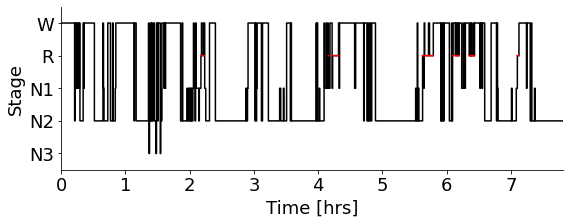

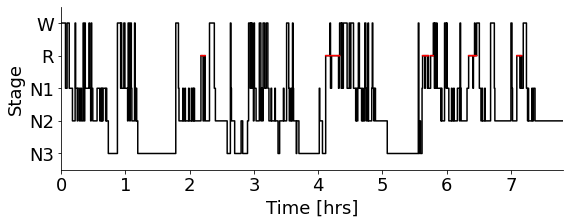

In [38]:
#sacamos caracteristicas 
#usamos esos canales porque son los recomendados
sls = yasa.SleepStaging(raw, eeg_name='C4-A1',eog_name="C3-A2", emg_name="X1")
hypno_pred = sls.predict()  # Predict the sleep stages
hypno_pred = yasa.hypno_str_to_int(hypno_pred)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred);  # Plot
yasa.plot_hypnogram(hypno1)

In [39]:
#las features que saca son estas:

sls.get_features()

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
0,0.901007,-0.069369,-0.074200,0.187992,1.452358,1.273609,1.333862,2.282928,1.322432,0.106543,...,-0.311772,-0.710103,1.396439,-0.224901,-0.039493,0.111529,-0.414296,-0.339945,0.000000,0.000000
1,1.557032,-0.073563,-0.030211,0.076429,1.458161,0.728989,1.166203,2.261841,1.211046,0.035482,...,-0.217604,-0.405754,1.017784,-0.243651,-0.124569,0.086895,-0.399007,-0.426485,0.008333,0.001066
2,0.936490,-0.081287,-0.043288,0.334774,1.491093,1.388227,3.415582,2.238868,2.170189,0.084412,...,-0.150985,-0.298019,0.925366,-0.259997,-0.166770,0.075597,-0.364281,-0.481793,0.016667,0.002132
3,1.101113,-0.088508,-0.044307,0.124773,1.429638,1.205264,1.453727,2.066136,1.998067,0.050253,...,-0.093081,-0.281130,0.862426,-0.274167,-0.194942,0.113904,-0.307250,-0.442159,0.025000,0.003198
4,0.580370,-0.096221,-0.055057,0.195046,1.378348,1.222482,1.253794,1.895557,1.971470,0.100486,...,-0.035518,-0.082469,0.824597,-0.285188,-0.259182,0.128599,-0.253223,-0.412174,0.033333,0.004264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,2.008678,0.074838,0.062022,0.044309,0.050410,0.103994,0.285804,0.036816,0.039430,0.007134,...,0.258696,-0.100367,1.980202,0.162545,0.081711,0.153681,0.163562,0.149871,7.783333,0.995736
935,2.194305,0.080639,0.058847,0.059753,0.034893,0.097617,0.487858,0.034855,0.081141,0.006712,...,0.317967,-0.030919,2.541245,0.190847,0.170103,0.137412,0.154702,0.103721,7.791667,0.996802
936,2.384556,0.088137,0.090917,0.044151,0.016499,-0.024598,0.283470,0.024895,0.024540,0.005904,...,0.391458,-0.016485,2.029875,0.215222,0.243456,0.160680,0.160661,0.017635,7.800000,0.997868


In [40]:
#no nos interesan todas las "epochs" porque algunas tienen anotaciones
indices=load_valid_data("../data/from_web/10/10_1.xlsx",return_bool_vect=False)
features_validas=sls.get_features().iloc[indices,]
print(features_validas.shape)
features_validas.head(10)

(604, 149)


,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
2,0.936490,-0.081287,-0.043288,0.334774,1.491093,1.388227,3.415582,2.238868,2.170189,0.084412,...,-0.150985,-0.298019,0.925366,-0.259997,-0.166770,0.075597,-0.364281,-0.481793,0.016667,0.002132
3,1.101113,-0.088508,-0.044307,0.124773,1.429638,1.205264,1.453727,2.066136,1.998067,0.050253,...,-0.093081,-0.281130,0.862426,-0.274167,-0.194942,0.113904,-0.307250,-0.442159,0.025000,0.003198
4,0.580370,-0.096221,-0.055057,0.195046,1.378348,1.222482,1.253794,1.895557,1.971470,0.100486,...,-0.035518,-0.082469,0.824597,-0.285188,-0.259182,0.128599,-0.253223,-0.412174,0.033333,0.004264
5,0.606624,-0.101633,-0.086921,0.285435,1.304244,1.732636,2.000244,1.730601,2.248523,0.100468,...,0.012770,-0.007166,0.811697,-0.292547,-0.282334,0.119737,-0.205790,-0.354485,0.041667,0.005330
6,0.545295,-0.105918,-0.100036,0.133833,1.175619,1.242168,1.015997,1.518813,1.451424,0.105894,...,0.057022,0.104117,0.764540,-0.295818,-0.300401,0.156145,-0.162975,-0.212998,0.050000,0.006397
7,0.626285,-0.107965,-0.115956,0.191352,1.049022,1.404678,1.413317,1.314741,1.438000,0.083005,...,0.079325,0.195599,0.759308,-0.294840,-0.311985,0.126866,-0.130880,-0.190228,0.058333,0.007463
8,0.480886,-0.110269,-0.119291,0.184119,0.907142,1.378007,0.955826,1.091074,1.339020,0.122334,...,0.095466,0.150450,0.772039,-0.293635,-0.317890,0.134363,-0.095788,-0.180105,0.066667,0.008529
9,0.542486,-0.111603,-0.121441,0.088079,0.746343,0.896290,0.433896,0.861931,0.818707,0.073132,...,0.098045,0.063319,0.805214,-0.287871,-0.318618,0.213412,-0.057701,-0.015560,0.075000,0.009595
11,0.695301,-0.107610,-0.118301,0.066787,0.452141,0.415041,0.500473,0.513451,0.268565,0.063191,...,0.107213,-0.078974,0.939057,-0.270819,-0.295727,0.151097,-0.039311,0.178489,0.091667,0.011727


Antes de crear un modelo, vamos a usar el modelo que usa yasa para la predicción, pero solo vamos a tener en cuenta las predicciones de las épocas validas.

0.40894039735099336


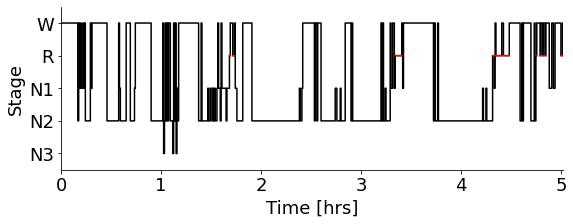

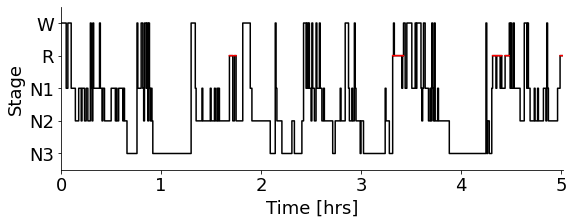

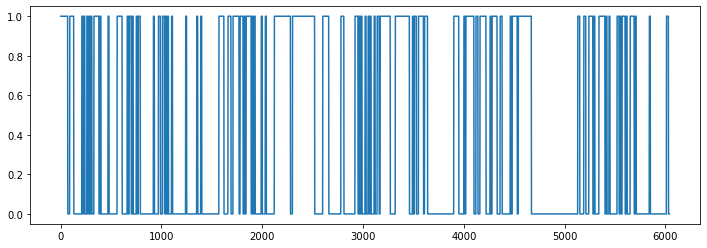

In [41]:
hypno_pred_epocas_validas=hypno_pred[indices]
yasa.plot_hypnogram(hypno_pred_epocas_validas);  # Plot
yasa.plot_hypnogram(hypno1.to_numpy()[indices])
#vamos a ver que tramos acierta
plt.figure(figsize=(12,4))
plt.plot(np.repeat(hypno1.to_numpy()[indices]==hypno_pred_epocas_validas,10))
print(sum(hypno1.to_numpy()[indices]==hypno_pred_epocas_validas)/hypno_pred_epocas_validas.size)

In [12]:
print(yasa.sleep_statistics(hypno1[indices],1/30))
print(yasa.sleep_statistics(hypno_pred_epocas_validas,1/30))

{'TIB': 302.0, 'SPT': 283.0, 'WASO': 39.5, 'TST': 243.5, 'N1': 60.5, 'N2': 61.0, 'N3': 55.5, 'REM': 66.5, 'NREM': 177.0, 'SOL': 19.0, 'Lat_N1': 19.0, 'Lat_N2': 36.5, 'Lat_N3': 64.5, 'Lat_REM': 75.5, '%N1': 24.84599589322382, '%N2': 25.05133470225873, '%N3': 22.792607802874745, '%REM': 27.310061601642712, '%NREM': 72.68993839835728, 'SE': 80.62913907284768, 'SME': 86.04240282685512}
{'TIB': 302.0, 'SPT': 244.0, 'WASO': 57.0, 'TST': 187.0, 'N1': 86.0, 'N2': 98.5, 'N3': 0.0, 'REM': 2.5, 'NREM': 184.5, 'SOL': 58.0, 'Lat_N1': 58.0, 'Lat_N2': 59.5, 'Lat_N3': nan, 'Lat_REM': 255.5, '%N1': 45.98930481283423, '%N2': 52.67379679144385, '%N3': 0.0, '%REM': 1.3368983957219251, '%NREM': 98.66310160427807, 'SE': 61.920529801324506, 'SME': 76.63934426229508}


In [13]:
#lo ideal seria entrenar el modelo con una parte de los datos
#veamos las características que nos devuelve esto
features_validas


,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
2,9.138662,0.554187,0.882301,0.045789,-0.189944,-0.166145,1.369552,0.961332,1.208972,0.307645,...,-0.398026,0.030283,2.649097,0.682770,0.766775,0.029917,-0.726108,-0.726987,0.016667,0.002614
3,0.534905,0.486342,0.645637,0.092836,-0.194016,-0.078982,0.578807,0.906052,0.963898,0.241860,...,-0.391529,-0.357251,1.180217,0.654879,0.586327,0.091743,-0.717335,-0.671986,0.025000,0.003922
4,3.831923,0.440218,0.687099,0.046932,-0.210379,-0.097500,1.095649,0.881545,0.956558,0.290713,...,-0.322792,-0.565557,2.971700,0.646562,0.632181,0.036692,-0.714738,-0.679854,0.033333,0.005229
5,2.367151,0.382409,0.770778,0.065932,-0.216896,-0.137201,1.281696,0.853659,1.129165,0.235715,...,-0.235801,-0.588782,2.644276,0.610511,0.773964,0.076616,-0.704430,-0.688613,0.041667,0.006536
6,1.311654,0.323766,0.294802,0.033587,-0.225515,-0.169748,0.439620,0.797890,0.712650,0.188572,...,-0.139225,-0.608672,1.360446,0.559861,0.575125,0.073731,-0.693738,-0.628327,0.050000,0.007843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,1.691552,0.099097,0.167385,0.054593,0.036568,-0.046280,0.308991,-0.039594,-0.024766,0.012472,...,-0.758464,-0.169160,1.661205,0.155709,0.202878,0.156434,-0.001342,-0.134006,6.341667,0.994771
762,0.828866,0.081542,0.134056,0.112335,0.080988,-0.000163,0.446853,-0.013878,-0.102104,0.037525,...,-0.903783,-0.874000,1.300725,0.141683,0.199207,0.240341,0.022529,0.019206,6.350000,0.996078
763,0.971008,0.066733,0.111589,0.066230,0.113736,-0.065376,0.373269,0.012257,-0.185123,0.023103,...,-0.935484,-0.969287,1.126127,0.130130,0.184918,0.186892,0.031398,0.012643,6.358333,0.997386


In [42]:
#tenemos una cantidad enorme de dimensiones, vamos a probar con un PCA y un LDA

from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

# PCA

In [43]:
#vamos a hacer una reducción de la dimension porque para empezar, tenermos muchas dimensiones muy similares
#primero de todo, debemos de escalar las variables, porque el PCA las centra, pero no las escala
#simplemente aremos un standarscaler
scale=StandardScaler()
data_4_pca=scale.fit_transform(features_validas)

pca=PCA(n_components=15)
x_pca=pca.fit_transform(data_4_pca)

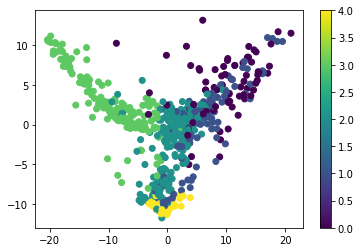

In [44]:
plt.scatter(x_pca[:,0],x_pca[:,1],c=hypno1[indices])
plt.colorbar()

# KPCA

In [45]:
#hacemos lo mismo pero para el kernel pca
kpca=KernelPCA(n_components=15,kernel="rbf")
x_kpca=kpca.fit_transform(data_4_pca)

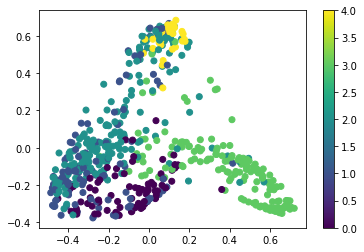

In [46]:
plt.scatter(x_kpca[:,0],x_kpca[:,1],c=hypno1[indices])
plt.colorbar()

In [47]:
#con los resultados anteriores,a ver si la clasificacion se puede hacer mejor, 
#a ver si nos da para separar, teniendolo todo


# LDA

In [48]:
#vamos a probar un LDA, que nos fomenta justamente la separacion de clases
lda=LDA(n_components=4)
x_lda=lda.fit_transform(data_4_pca,hypno1[indices])

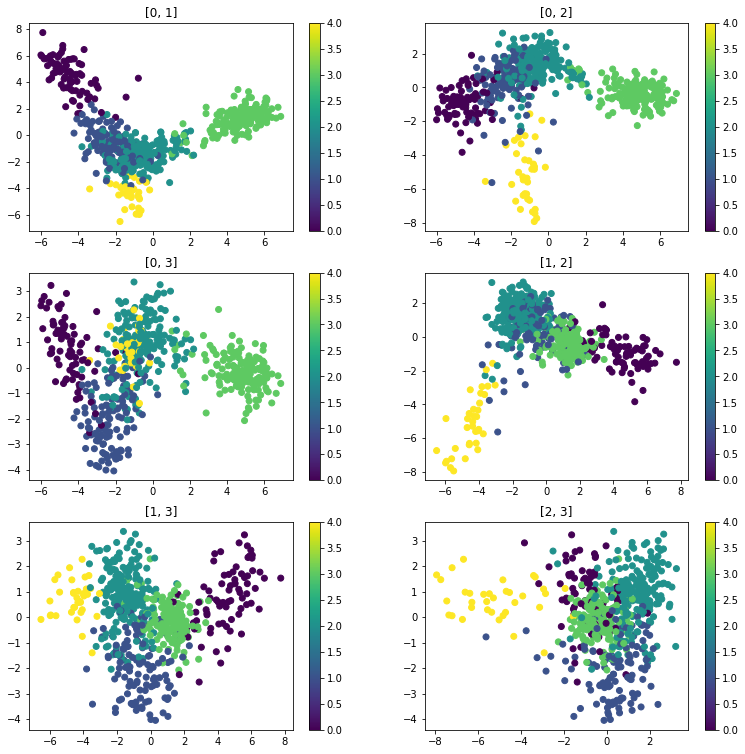

In [49]:
plt.figure(figsize=(13,13))
combinaciones=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.scatter(x_lda[:,combinaciones[i][0]],x_lda[:,combinaciones[i][1]],c=hypno1[indices])
    plt.title(combinaciones[i])
    plt.colorbar()

Parece que esto se separa de puta madre no?  
A ver si podemos hacer que esto se entrene con un 30 porciento y el resto de clasifique bien en base a eso.

# El modelo de clasificación  
Como modelo para la clasificación, vamos a usar un sencillo random forest, o un SVC tampoco mucho lio.  

In [50]:
#separamos datos
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_lda,hypno1[indices],test_size=0.2)

In [51]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC

### Random Forests

In [52]:
randomforest=RF()
randomforest.fit(x_train,y_train)

RandomForestClassifier()

In [53]:
y_pred=randomforest.predict(x_test)

In [54]:
accuracy_score(y_pred,y_test)

0.9421487603305785

In [55]:
#ahora voy a intentar lo de hacer la lda pero con el conjunto train solo tbn
#vamos a probar un LDA, que nos fomenta justamente la separacion de clases
lda=LDA(n_components=4)
x_train,x_test,y_train,y_test=train_test_split(data_4_pca,hypno1[indices],test_size=0.2)
x_lda_train=lda.fit_transform(x_train,y_train)
y_lda_pred=lda.predict(x_test)
x_lda_test=lda.transform(x_test)
randomforest=RF()
randomforest.fit(x_lda_train,y_train)
y_pred=randomforest.predict(x_lda_test)
print(accuracy_score(y_pred,y_test))
print(accuracy_score(y_lda_pred,y_test))

0.8181818181818182
0.7933884297520661


Podemos usar tanto la separacion que nos hace el metodo LDA que clusteriza (no se como), o podemos usar la transformación que nos da de los datos, para hacerle una clusterizacion mas compleja como por ejemplo un RF.  
El resultado con el random forest es mejor porque es capaz de definir mejor la frontera de separacion. 

### SVC

In [61]:
x_train,x_test,y_train,y_test=train_test_split(data_4_pca,hypno1[indices],train_size=0.3)
svc=SVC(probability=True)

In [62]:
svc.fit(x_train,y_train)

SVC(probability=True)

In [63]:
y_pred=svc.predict(x_test)

In [64]:
print(accuracy_score(y_pred,y_test))

0.7399527186761229


In [65]:
#a ver si funciona mejor lo anterior con pca,kpca o lda

x_train,x_test,y_train,y_test=train_test_split(data_4_pca,hypno1[indices],train_size=0.3)


#pca
pca=PCA(n_components=15)
x_pca=pca.fit_transform(x_train)
svc=SVC()
svc.fit(x_pca,y_train)
x_pca_test=pca.transform(x_test)
y_pred=svc.predict(x_pca_test)
print(accuracy_score(y_pred,y_test))

#kpca
kpca=KernelPCA(n_components=15,kernel="rbf")
x_kpca=kpca.fit_transform(x_train)
svc=SVC()
svc.fit(x_kpca,y_train)
x_kpca_test=kpca.transform(x_test)
y_pred=svc.predict(x_kpca_test)
print(accuracy_score(y_pred,y_test))

#lda
lda=LDA(n_components=4)
x_lda=lda.fit_transform(x_train,y_train)
svc=SVC()
svc.fit(x_lda,y_train)
x_lda_test=lda.transform(x_test)
y_pred=svc.predict(x_lda_test)
print(accuracy_score(y_pred,y_test))

0.7990543735224587
0.806146572104019
0.5130023640661938


Nada, ahora vamos a probar a hacer un ajuste con un 30% de los datos, a ver si con eso el 70 restante lo hace bien. Lo mejor seria que ese 30% fuera una pequeño finetuning y no el modelo entero....

He probado tanto con el paciente 10 como el 9 y los resultados salen muy parecidos.

In [70]:
#voy a usar el kernePCA y voy a probar a modificar los umbrales de probabilidad para mejorar los resultados
#y para descartar los que nos salgan mal

kpca=KernelPCA(n_components=15,kernel="rbf")
x_kpca=kpca.fit_transform(x_train)
svc=SVC(probability=True)
svc.fit(x_kpca,y_train)
x_kpca_test=kpca.transform(x_test)
y_pred=svc.predict(x_kpca_test)
print(accuracy_score(y_pred,y_test))


0.806146572104019


 The stages are mapped to integers such that 0 = Wake, 1 = N1 sleep, 2 = N2 sleep, 3 = N3 sleep and 4 = REM sleep

In [73]:
y_probs=svc.predict_proba(x_kpca_test)

In [78]:
a,b=count_by_thresh(y_probs,umbrales=[0.5,0.5,0.5,0.5,0.5])

In [84]:
def accuracy_mejorada(y_pred,y_true):
    #vamos a darle las etiquetas reales, y una lista de las que han superado cierto humbral
    #y nos devuelve la precision de si alguna de las reales, esta entre las consideradas,
    #y para los periodos que no tenemos nada seguro, no se tiene en cuenta
    aciertos=0
    totales=0
    for i,j in enumerate(y_true):
        if y_pred[i]!=-1:
            #si hay una lectura valida entramos y contamos una de totales
            totales+=1
            if j in y_pred[i]:
                #si esta, consideramos un win y sumamos un punto
                aciertos+=1
            else:
                #si no esta, nada, es un fallo
                pass
        else:
            #si no hay estados relevantes, pasamos
            pass
        
    #al final, devolvemos el cociente
    return aciertos/totales
                

In [85]:
accuracy_mejorada(b,y_test)

0.8195876288659794

In [87]:
#vamos a ver de cada etapa, que estados son más altos y tal


y_probs[y_test.to_numpy()]

array([1, 3, 3, 0, 3, 0, 0, 3, 2, 1, 4, 3, 3, 2, 1, 2, 3, 1, 3, 2, 2, 1,
       2, 3, 2, 2, 2, 2, 2, 0, 0, 3, 2, 2, 1, 1, 3, 0, 4, 1, 0, 3, 0, 2,
       3, 1, 2, 3, 2, 2, 1, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 0, 2,
       3, 1, 3, 3, 2, 3, 3, 0, 3, 0, 2, 3, 1, 2, 2, 2, 0, 1, 1, 0, 3, 2,
       2, 2, 4, 3, 2, 3, 3, 1, 1, 1, 2, 0, 2, 1, 0, 4, 4, 3, 3, 0, 2, 2,
       2, 3, 3, 1, 1, 4, 3, 1, 1, 2, 3, 1, 2, 2, 4, 2, 3, 1, 2, 2, 0, 3,
       0, 2, 3, 0, 0, 0, 3, 3, 3, 2, 0, 3, 2, 2, 4, 0, 1, 3, 2, 3, 3, 3,
       2, 2, 3, 2, 0, 1, 1, 1, 2, 3, 1, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 1,
       1, 1, 3, 1, 3, 0, 2, 0, 4, 3, 2, 3, 1, 2, 3, 2, 4, 4, 2, 2, 2, 3,
       2, 1, 1, 1, 2, 2, 3, 0, 1, 2, 2, 3, 3, 3, 2, 0, 3, 3, 3, 2, 2, 2,
       2, 3, 2, 0, 2, 2, 1, 4, 4, 2, 3, 1, 2, 2, 1, 3, 2, 3, 3, 0, 2, 3,
       1, 4, 2, 1, 0, 2, 3, 3, 2, 3, 1, 4, 1, 2, 1, 3, 3, 2, 2, 4, 1, 2,
       3, 2, 2, 0, 0, 2, 0, 2, 3, 3, 4, 0, 2, 1, 0, 2, 2, 1, 3, 2, 0, 1,
       3, 0, 0, 3, 1, 3, 2, 3, 2, 4, 3, 3, 2, 4, 2,

In [ ]:
for i in range():
    for j in range():
        a,b=count_by_thresh(y_probs,umbrales=[0.5,0.5,0.5,0.8,0.5])
        print(i,j,accuracy_mejorada(b,y_test))
        print("\n")

Y por ultimos para determinar los mejores humbrales, vamos a probar distintos umbrales. Pero no es tan sencillo, porque si pones un umbral muy bajo, directamente todos los estados valen y acierta seguro, hay que regularizar esto por medio de dos parámetros.

1. El valor de umbral, que lo queremos lo más alto posible.  
2. Por la cantidad de estados que nos separa ese umbral, es decir, preferimos que no nos diga que esta mas o menos entre 4 estados posibles, sino que nos indique que solo hay 1 posible.  

In [105]:
y_aux=y_test.to_numpy()
probs_truevalues=[j[y_aux[i]] for i,j in enumerate(y_probs)]
probs_truevalues=np.array(probs_truevalues)

In [134]:
#vamos a ver que rangos de probs se gastan en cada uno de los estados
aux=[]
for i in range(5):
    valores=probs_truevalues[y_test==i]
    aux.append(valores)
#aux=np.array(aux)

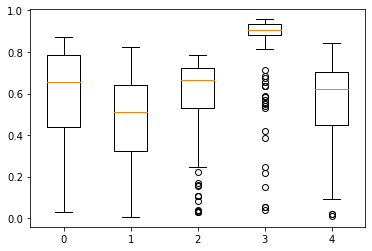

In [137]:
fig, ax = plt.subplots()
ax.boxplot(aux)
ax.set_xticklabels(range(5));


In [250]:
a,b=count_by_thresh(y_probs,umbrales=[0.1,0.4,0.2,0.9,0.5])
accuracy_mejorada(b,y_test)

0.8275

In [257]:
#como no podemos variar todo, vamos a dejar en 0.5 todas y a variar solo una, 
#para mediante el metodo del codo, ver donde estaria bien el umbral
val1=[]
umbrales=[0.5,0.5,0.5,0.5,0.5]
x=np.arange(0.1,0.99,0.05)
for i in range(5):
    val2=[]
    for j in x:
        umbrales_new=umbrales.copy()
        umbrales_new[i]=j
        a,b=count_by_thresh(y_probs,umbrales=umbrales_new)
        val2.append(accuracy_mejorada(b,y_test))
    val1.append(np.array(val2))
val=np.array(val1)

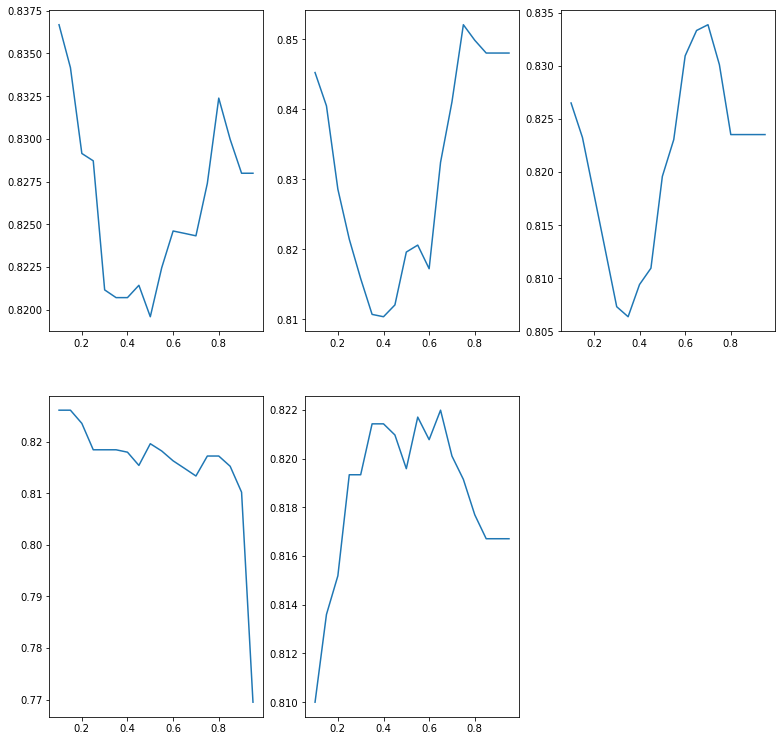

In [265]:
plt.figure(figsize=(13,13))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.plot(x,val[i])

In [273]:
a,b=count_by_thresh(y_probs,umbrales=[0.6,0.7,0.7,0.8,0.7])
#y cuantos del total hemos clasificado
total=len(a)
clasif=sum([1 for i in a if i!=-1])
print(clasif,total,clasif/total)
accuracy_mejorada(b,y_test)

233 423 0.5508274231678487


0.8755364806866953

Hemos clasificado la mitad, pero con una precisión de 0.87, nada mal.

## intento de regularización de los umbrales para sacar los mejores valores lo mas altos posibles


In [237]:
#vamos a definir un índice que sea los umbrales multiplicados por la precision y sumados y divididos entre 5
def score(umbrales,precision,n_stages=5,pos=0):
    umbrales_aux=umbrales#.copy()
    umbrales_aux[pos]=1
    return np.sum([i*precision for i in umbrales])-np.sum([i*precision for i in umbrales_aux])

In [238]:
def calcular_score(umbrales,y_probs,pos):
    a,b=count_by_thresh(y_probs,umbrales=[0.1,0.4,0.2,0.9,0.1])
    acc_aux=accuracy_mejorada(b,y_test)
    return score(umbrales,acc_aux,pos=pos)


In [239]:
calcular_score([0.1,0.5,0.5,0.9,0.1],y_probs)

TypeError: calcular_score() missing 1 required positional argument: 'pos'

In [242]:
valores=[]
for i in np.arange(0.1,1,0.005):
    valores.append(calcular_score([0.5,0.5,0.5,i,0.5],y_probs,pos=2))

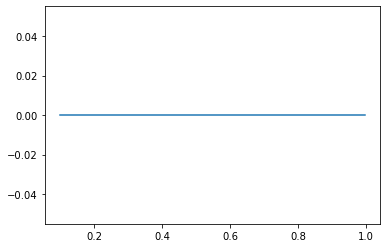

In [243]:
plt.plot(np.arange(0.1,1,0.005),valores)

In [244]:
np.arange(0.1,1,0.005).shape

(180,)

In [245]:
#esto no esta funcionando, pero intento regularizar esta vaina...